# 03 Evaluate fastText

## TODO

- auto split train and valid
- auto epoch
- print samples (DONE)

In [1]:
import fasttext

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
# Hjælpefunktion til at omregne til procent
def to_perc(a, b):
    return a / (a+b) * 100

In [17]:
# Funktion til at returnére den mest optimale epoch iteration af datasættet
def model_trainer():
    models_train = []
    models_valid = []
    peak_epoch = 0
    peak_value = 0.0

    with tqdm(total=epoch) as progress:
        for i in range(epoch):
            progress.update(1)

            model = fasttext.train_supervised(input=data_train, epoch=i, lr=lr, wordNgrams=wordNgrams, bucket=bucket, dim=dim, loss=loss)

            models_train.append(model.test(data_train, k=top_labels))
            models_valid.append(model.test(data_valid, k=top_labels))
            
            if (len(models_train) == 1):
                print('             Training  |    Validation')
                print('        ', '{0:6}'.format(models_train[i][0]), '{:.1f}'.format(to_perc(models_train[i][0], models_valid[i][0])) + '%',
                      ' | ', '{0:6}'.format(models_valid[i][0]), '{:.1f}'.format(to_perc(models_valid[i][0], models_train[i][0])) + '%')
                print('                       |')
                print('Epoch   ', 'Prec.', 'Recall  | ', 'Prec.', 'Recall')
                print('-----------------------+---------------------------')
            
            if (models_valid[i][1] > peak_value):
                peak_value = models_valid[i][1]
                peak_epoch = i+1
                precision = '\033[92mHigher\033[0m'
            else:
                precision = '\033[91mLower\033[0m'

            print('{0:2}'.format(i+1), ' ==> ', '{:.3f}'.format(models_train[i][1]), ' {:.3f}'.format(models_train[i][2]),
                  ' |', ' {:.3f}'.format(models_valid[i][1]), ' {:.3f}'.format(models_valid[i][2]), ' ==> ', precision)

        print('\n    -->  Epoch peaked at', '\033[1m' + '\033[94m' + str(peak_epoch))

        model = fasttext.train_supervised(input=data_train, epoch=peak_epoch-1, lr=lr, wordNgrams=wordNgrams, bucket=bucket, dim=dim, loss=loss)
        model.save_model('./data/fasttext_trained_model.bin')
        
        return peak_epoch, models_train, models_valid

In [4]:
# Visualisér modellen via plotting
def model_plot(title, i, model_valid_epoch, models_train, models_valid):
    threshold = 0.2
    y_range_min = min([y[i] for y in models_valid if y[i] > threshold])
    y_range_max = max([y[i] for y in models_train if y[i] > threshold])
    
    plt.plot([pr[i] for pr in models_train], label='Training')
    plt.plot([pr[i] for pr in models_valid], label='Validation')
    plt.axvline(model_valid_epoch-1, linewidth=2, color='g', linestyle='--', label=('Epoch Peak'))

    plt.title('Model (' + title + ')')
    plt.ylabel(title)
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.ylim([y_range_min, y_range_max+0.01])
    
    return plt.show()

             Training  |    Validation
           4998 69.2%  |    2229 30.8%
                       |
Epoch    Prec. Recall  |  Prec. Recall
-----------------------+---------------------------
 1  ==>  0.040  0.079  |  0.041  0.083  ==>  Higher
 2  ==>  0.433  0.865  |  0.424  0.848  ==>  Higher
 3  ==>  0.433  0.865  |  0.424  0.848  ==>  Lower
 4  ==>  0.438  0.877  |  0.430  0.860  ==>  Higher
 5  ==>  0.445  0.890  |  0.434  0.869  ==>  Higher
 6  ==>  0.449  0.898  |  0.439  0.878  ==>  Higher
 7  ==>  0.450  0.900  |  0.441  0.882  ==>  Higher
 8  ==>  0.452  0.904  |  0.443  0.886  ==>  Higher
 9  ==>  0.453  0.906  |  0.445  0.889  ==>  Higher
10  ==>  0.453  0.907  |  0.446  0.893  ==>  Higher
11  ==>  0.454  0.907  |  0.447  0.894  ==>  Higher
12  ==>  0.454  0.908  |  0.448  0.896  ==>  Higher
13  ==>  0.454  0.908  |  0.449  0.899  ==>  Higher
14  ==>  0.454  0.908  |  0.450  0.900  ==>  Higher
15  ==>  0.454  0.908  |  0.450  0.900  ==>  Higher
16  ==>  0.454  0.908  |  0

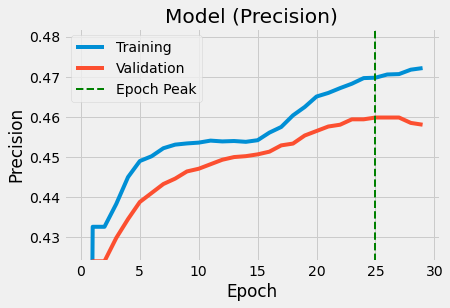

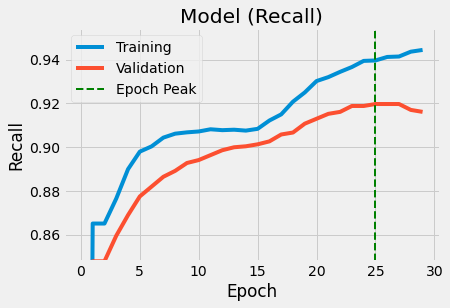

In [18]:
# Træn modellen ud fra givne parameter
data_train = './data/test.train'
data_valid = './data/test.valid'
epoch      = 30
lr         = 0.1
wordNgrams = 2
bucket     = 20000
dim        = 100
loss       = 'ova'
top_labels = 2

mt = model_trainer()
model_plot('Precision', 1, mt[0], mt[1], mt[2])
model_plot('Recall', 2, mt[0], mt[1], mt[2])